In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pickle import dump,load
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import  MultivariateNormal
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
sys.path.insert(0, parent_dir)
import gptransform as gptransform
torch.set_default_dtype(torch.float64)

In [2]:
σOO = 0.0374
σOH = - 0.0964
σHH = 0.0622

σOHD = 0.0378
σHD = 0.0096

σOD = 0.1721 
σDD = 0.1978

M = torch.tensor([[σOO, σOH , σHH],
                  [σOO, σOHD, σHD],
                  [σOO, σOD , σDD]])


M_inv = torch.linalg.inv(M)

### Data Imports of Raw FQ Datum ### 

# Choose which datapoints to import
every = 2 # only get 'every' other data point
ditch = 7 # exclude the last 'ditch' data points

# Define the temperature and deuteration types with corresponding run numbers from the table
data_config = [
    {'temp': 5,  'types': {'H2O': 676, 'HDO': 678, 'D2O': 679},'density': 33.43},  # or 7 instead of 5 if necessary
    {'temp': 15, 'types': {'H2O': 684, 'HDO': 686, 'D2O': 687},'density': 33.33},
    {'temp': 22, 'types': {'H2O': 644, 'HDO': 645, 'D2O': 647},'density': 33.43},
    {'temp': 40, 'types': {'H2O': 688, 'HDO': 690, 'D2O': 691},'density': 33.2},
    {'temp': 70, 'types': {'H2O': 692, 'HDO': 694, 'D2O': 695},'density': 32.7},
    {'temp': 92, 'types': {'H2O': 696, 'HDO': 698, 'D2O': 699},'density': 33.27}
     ]


# Dictionary to store imported data
data_dict_deuteration = {}

# Loop over temperatures and deuteration types
# Access the data using, e.g., data_dict[22]['H2O']['q'] for q values of H2O at 22°C
for config in data_config:
    temp = config['temp']
    data_dict_deuteration[temp] = {}
    
    for fluid, run_number in config['types'].items():
        file_path = f"Datasets/NIMROD00000{run_number}.mint01"
        
        # Load data from file
        my_data = np.genfromtxt(file_path, skip_header=14)[::every]
        q_values = torch.unsqueeze(torch.tensor(my_data.T[0]), dim=1)[:-ditch]
        sq_values = torch.unsqueeze(torch.tensor(my_data.T[1]), dim=1)[:-ditch]
        
        # Store in dictionary
        data_dict_deuteration[temp][fluid] = {'q': q_values, 'sq': sq_values}

data_dict_types = {}
for config in data_config:
    temp = config['temp']
    data_dict_types[temp] = {}
    
    structure_total_q_noisey = torch.zeros((3,len(q_values)))
    structure_total_q_noisey[0] = data_dict_deuteration[temp]['H2O']['sq'].T[0]
    structure_total_q_noisey[1] = data_dict_deuteration[temp]['HDO']['sq'].T[0]
    structure_total_q_noisey[2] = data_dict_deuteration[temp]['D2O']['sq'].T[0]
    structure_partial_q_noisey = (M_inv @ structure_total_q_noisey)
#     structure_partial_q_noisey += 0.05*torch.randn(structure_partial_q_noisey.size())
    
    perm = torch.randperm(len(structure_total_q_noisey[0]))

    # Put into Pytorch Dataloader
    dataset_OO = gptransform.data(q_values[perm].reshape(1,490,1),structure_partial_q_noisey[0][perm].reshape(1,490,1))
    dataset_OH = gptransform.data(q_values[perm].reshape(1,490,1),structure_partial_q_noisey[1][perm].reshape(1,490,1))
    dataset_HH = gptransform.data(q_values[perm].reshape(1,490,1),structure_partial_q_noisey[2][perm].reshape(1,490,1))
    
    data_dict_types[temp]['perm'] = perm
    data_dict_types[temp]['OO_dataset'] = dataset_OO
    data_dict_types[temp]['OH_dataset'] = dataset_OH
    data_dict_types[temp]['HH_dataset'] = dataset_HH
    
    data_dict_types[temp]['OO'] = structure_partial_q_noisey[0].unsqueeze(dim=1)
    data_dict_types[temp]['OH'] = structure_partial_q_noisey[1].unsqueeze(dim=1)
    data_dict_types[temp]['HH'] = structure_partial_q_noisey[2].unsqueeze(dim=1)

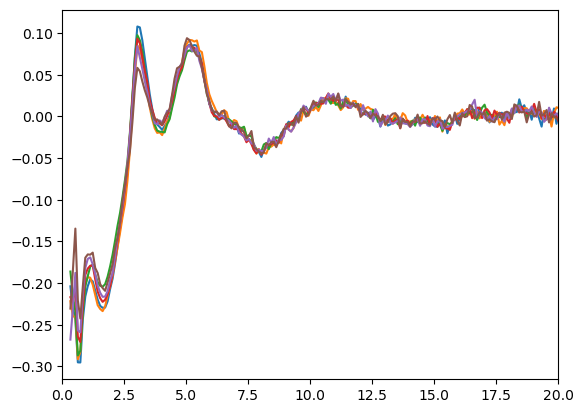

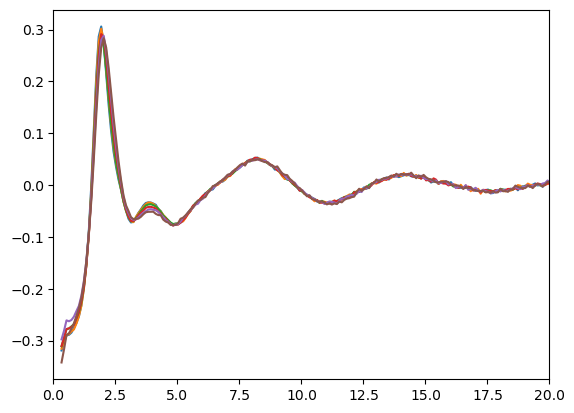

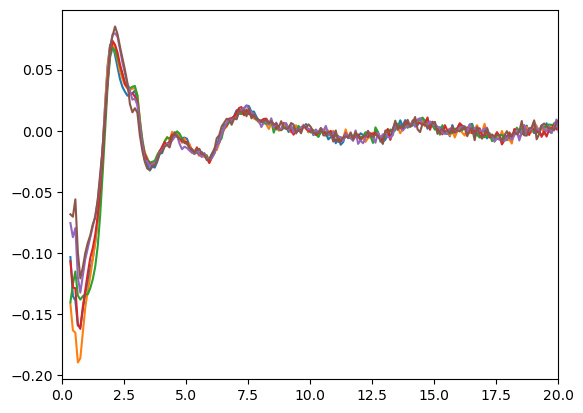

In [3]:
for config in data_config:
    temp = config['temp']
    plt.plot(data_dict_deuteration[temp]['H2O']['q'],data_dict_deuteration[temp]['H2O']['sq'],label=temp)
plt.xlim(0,20)
plt.show()

for config in data_config:
    temp = config['temp']
    plt.plot(data_dict_deuteration[temp]['D2O']['q'],data_dict_deuteration[temp]['D2O']['sq'],label=temp)
plt.xlim(0,20)
plt.show()

for config in data_config:
    temp = config['temp']
    plt.plot(data_dict_deuteration[temp]['HDO']['q'],data_dict_deuteration[temp]['HDO']['sq'],label=temp)
plt.xlim(0,20)
plt.show()

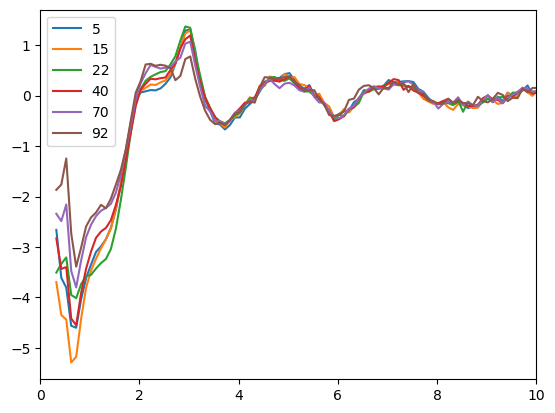

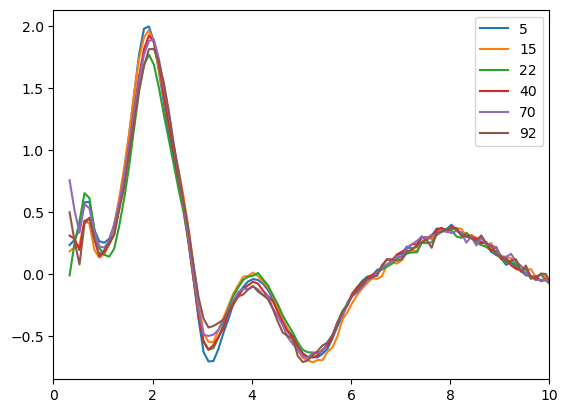

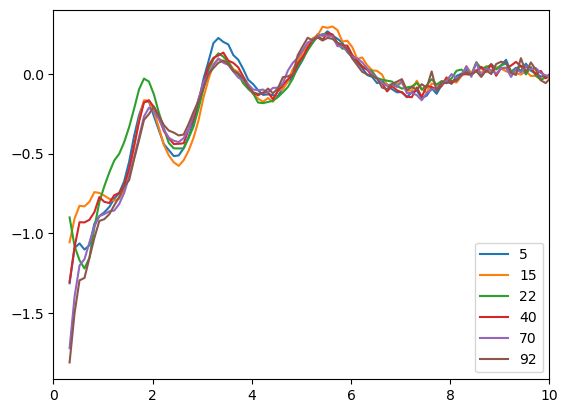

In [4]:
for config in data_config:
    temp = config['temp']
    plt.plot(q_values,data_dict_types[temp]['OO'],label=temp)
plt.xlim(0,10)
plt.legend()
plt.show()

for config in data_config:
    temp = config['temp']
    plt.plot(q_values,data_dict_types[temp]['OH'],label=temp)
plt.xlim(0,10)
plt.legend()
plt.show()

for config in data_config:
    temp = config['temp']
    plt.plot(q_values,data_dict_types[temp]['HH'],label=temp)
plt.xlim(0,10)
plt.legend()
plt.show()

In [5]:
r_grid =  torch.linspace(0.0001, 40, 1000).reshape(-1,1)
r_infer = torch.linspace(0.0001, 40, 1000).reshape(-1,1)
q_infer = q_values

bond_count = {
    'OH': 1,
}

ylims = {
    'HHlo': -2,
    'OHlo': -1,
    'OOlo': -6,
    'HHhi': 0.5,
    'OHhi': 2.1,
    'OOhi': 2
}

temps = [5,15,22,40,70,92]

Running: OH at T = 5
Average loss: 278472.436951  [    0/  500]
l:       0.967769 
max:     1.897164 
slope:   5.870641 
loc:     3.081610 
decay:   0.937838 
sigma_n: 0.035432 
r_0:     3.081610 
s:       49.555308 
h:   0.197149 
r:   0.577761 
s:   0.098648 
Minutes Taken Since Last Report: 0.075549 



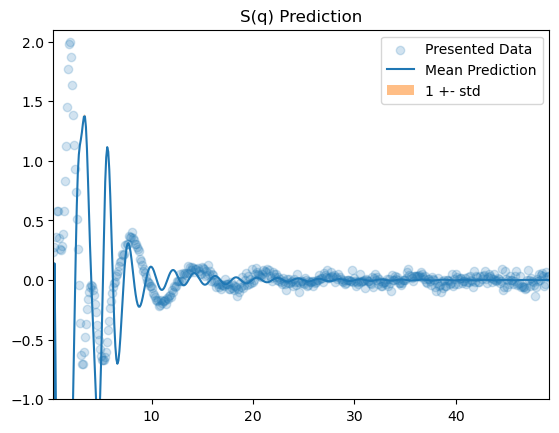

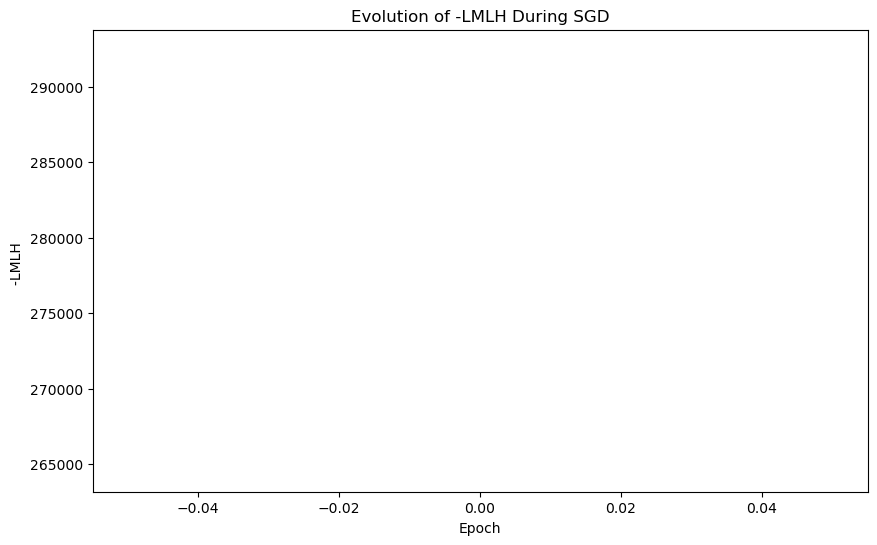

Average loss: -201.013942  [   25/  500]
l:       0.517221 
max:     4.194552 
slope:   2.887986 
loc:     1.902237 
decay:   0.977668 
sigma_n: 0.076427 
r_0:     1.842299 
s:       49.537046 
h:   0.555731 
r:   0.785189 
s:   0.099655 
Minutes Taken Since Last Report: 1.074458 



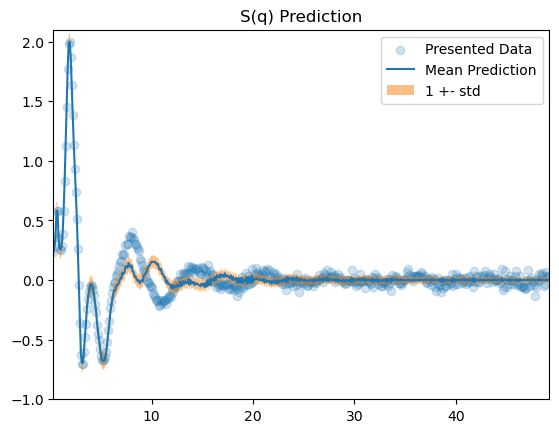

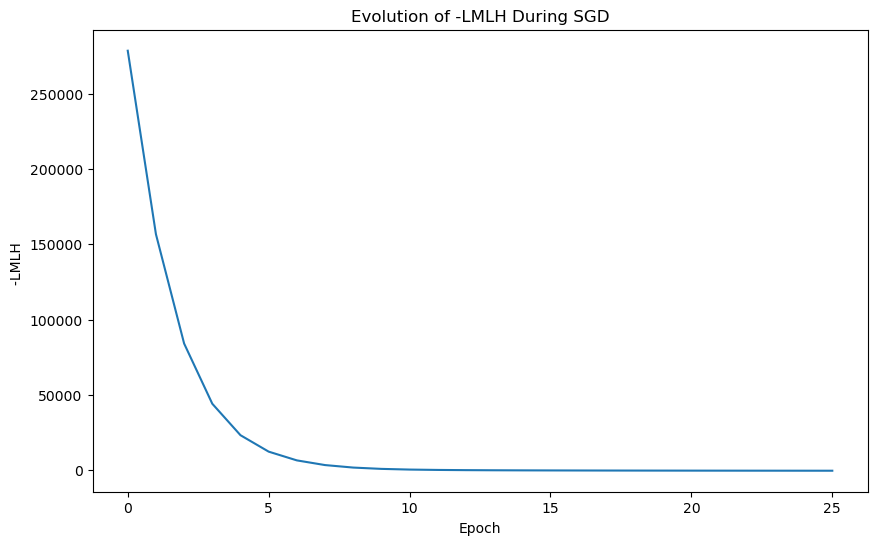

Average loss: -435.691237  [   50/  500]
l:       0.479863 
max:     4.500291 
slope:   2.724144 
loc:     1.812972 
decay:   0.979801 
sigma_n: 0.081533 
r_0:     1.750276 
s:       49.358575 
h:   0.597347 
r:   1.012985 
s:   0.099764 
Minutes Taken Since Last Report: 0.896380 



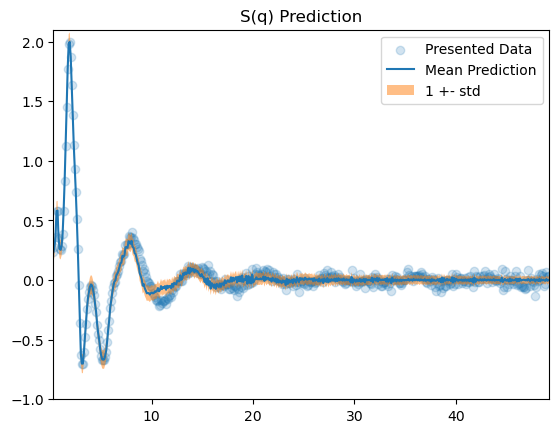

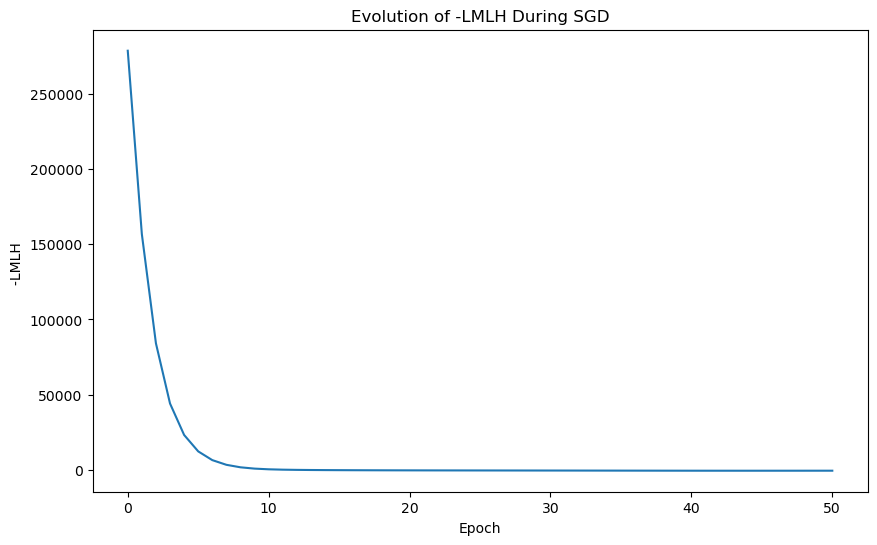

Average loss: -433.831576  [   75/  500]
l:       0.474751 
max:     4.526545 
slope:   2.709355 
loc:     1.804085 
decay:   0.980042 
sigma_n: 0.081705 
r_0:     1.750523 
s:       49.053506 
h:   0.626611 
r:   0.958595 
s:   0.099728 
Minutes Taken Since Last Report: 1.116873 



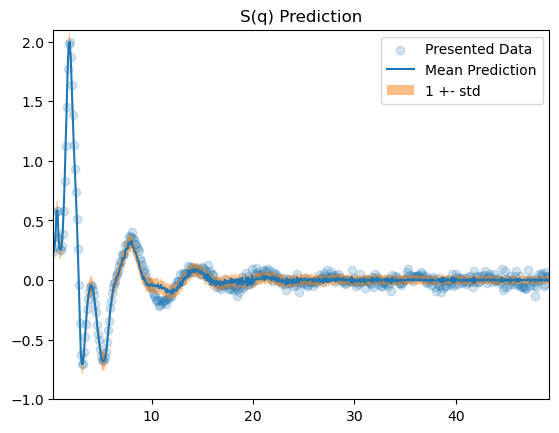

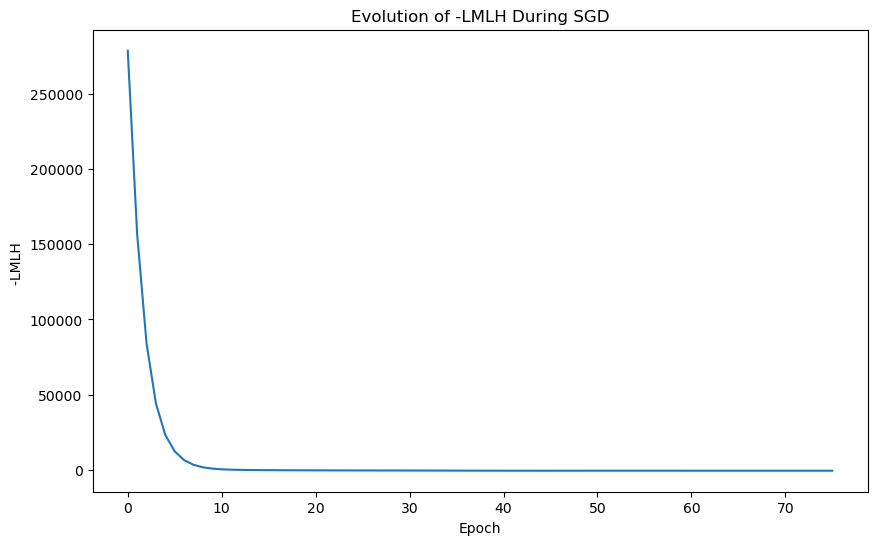

Average loss: -439.386584  [  100/  500]
l:       0.473376 
max:     4.522276 
slope:   2.707985 
loc:     1.802613 
decay:   0.980122 
sigma_n: 0.081302 
r_0:     1.754912 
s:       48.146940 
h:   0.663527 
r:   0.973089 
s:   0.099632 
Minutes Taken Since Last Report: 0.972690 



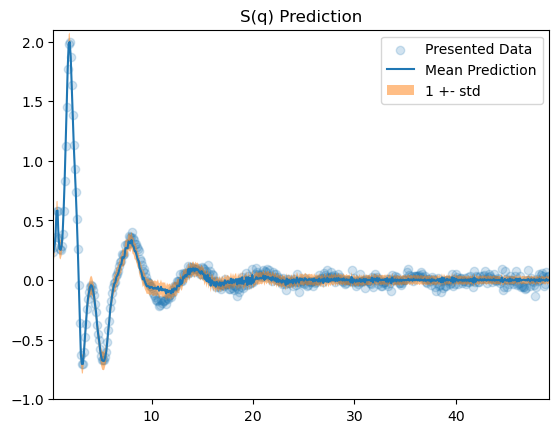

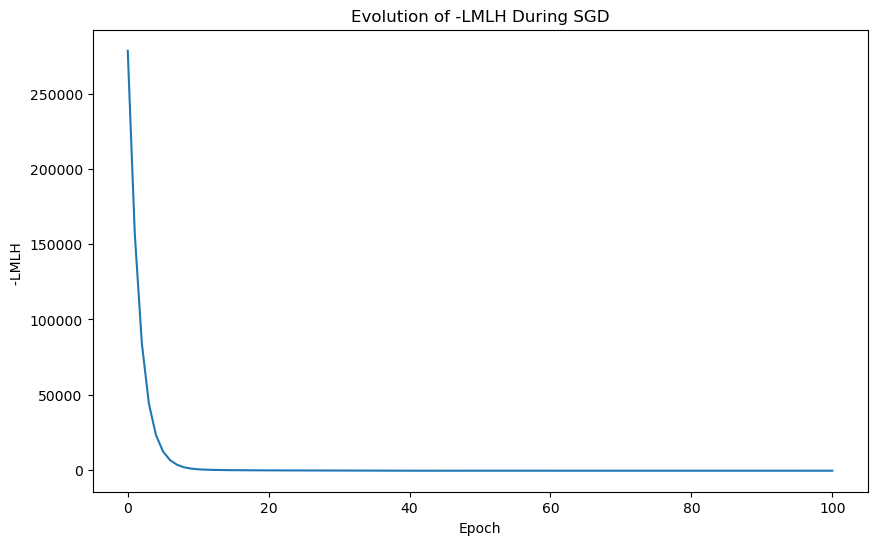

Average loss: -445.726523  [  125/  500]
l:       0.472476 
max:     4.513793 
slope:   2.707826 
loc:     1.801743 
decay:   0.980194 
sigma_n: 0.080776 
r_0:     1.764897 
s:       40.507161 
h:   0.706530 
r:   0.973771 
s:   0.099406 
Minutes Taken Since Last Report: 0.936074 



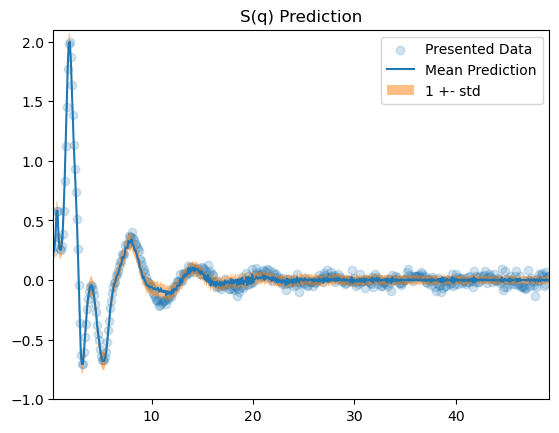

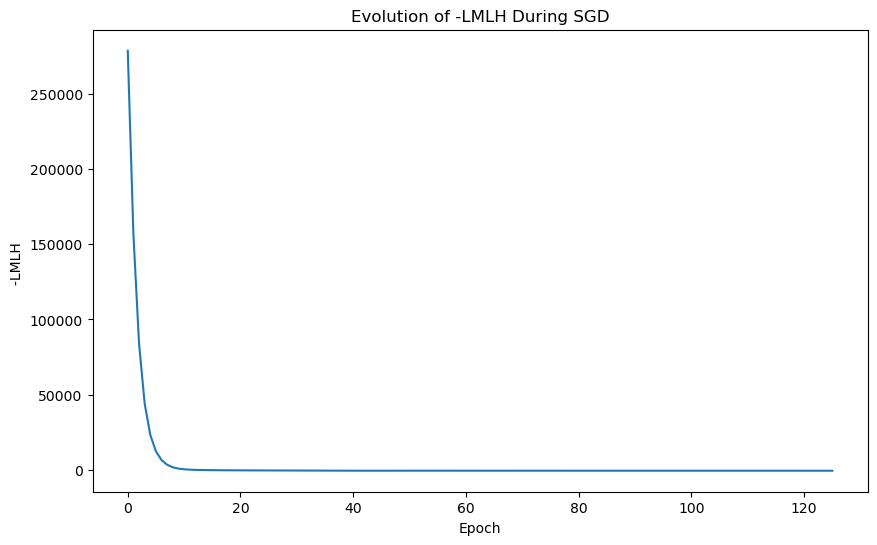

Average loss: -461.814671  [  150/  500]
l:       0.472399 
max:     4.502251 
slope:   2.707807 
loc:     1.800962 
decay:   0.980270 
sigma_n: 0.080152 
r_0:     1.773200 
s:       1.530125 
h:   0.751502 
r:   0.971540 
s:   0.098613 
Minutes Taken Since Last Report: 0.984961 



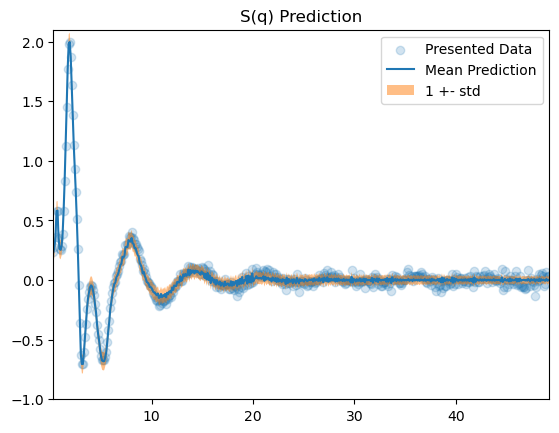

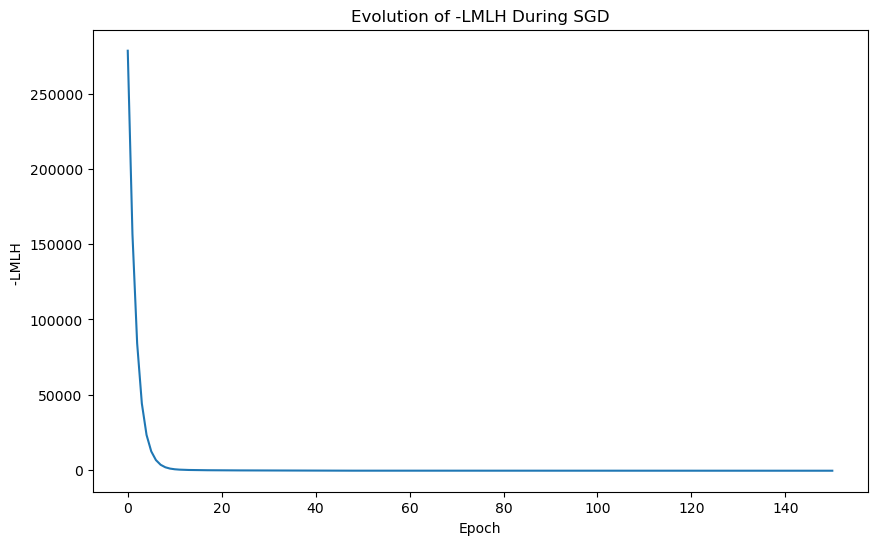

Average loss: -469.214695  [  175/  500]
l:       0.473934 
max:     4.485833 
slope:   2.707921 
loc:     1.800366 
decay:   0.980348 
sigma_n: 0.079421 
r_0:     1.773628 
s:       1.126378 
h:   0.791213 
r:   0.971468 
s:   0.088488 
Minutes Taken Since Last Report: 0.913673 



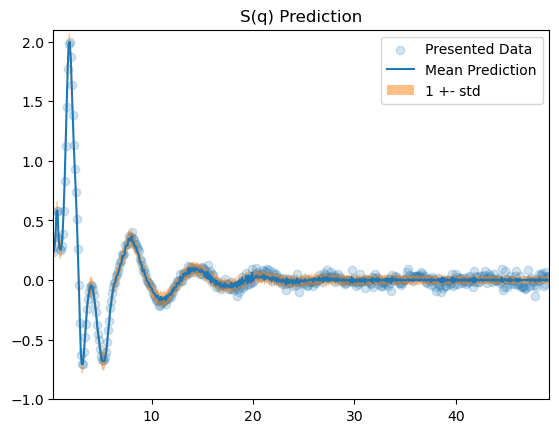

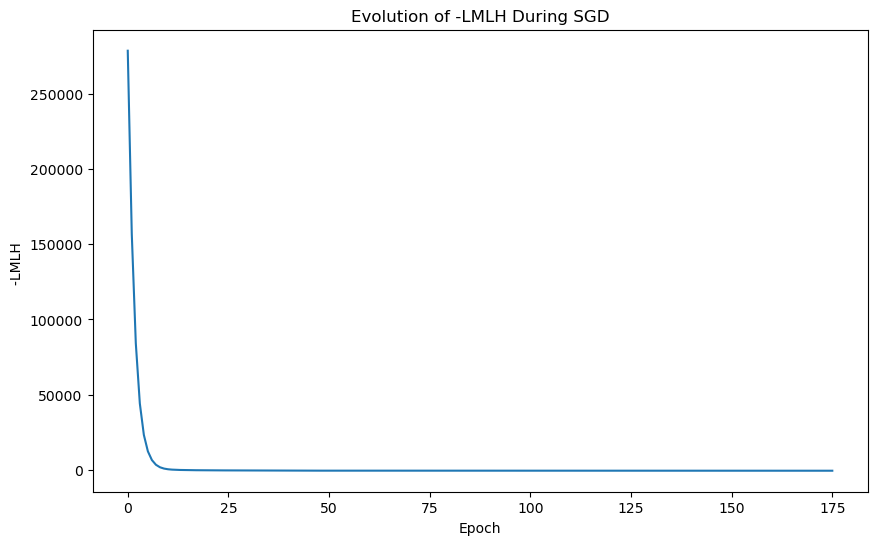

Average loss: -476.676577  [  200/  500]
l:       0.476254 
max:     4.466625 
slope:   2.708093 
loc:     1.799842 
decay:   0.980430 
sigma_n: 0.078597 
r_0:     1.773117 
s:       0.952855 
h:   0.803860 
r:   0.971787 
s:   0.079350 
Minutes Taken Since Last Report: 0.972330 



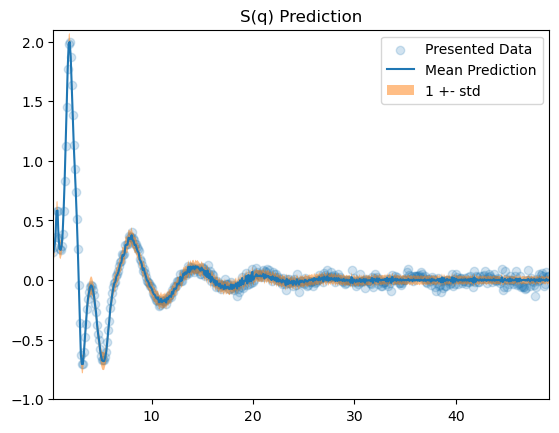

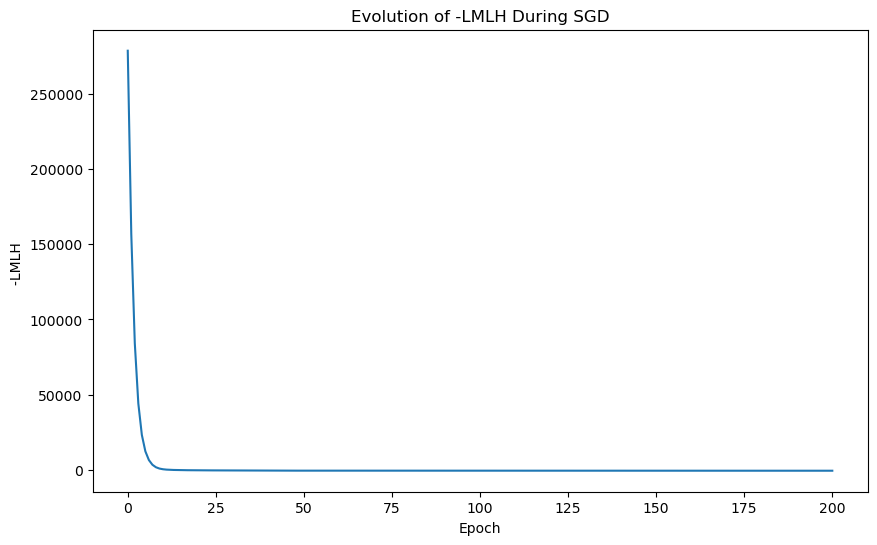

KeyboardInterrupt: 

In [12]:
temp_index = 0
for config in data_config:
    temp = config['temp']
    density = config['density']
    
    for psq_name in bond_count:
        
            try:
                # Model class must be defined somewhere
                gp = torch.load('models/'+str(temp)+'_'+psq_name+'_GP', weights_only=False)
                gp.eval()
            
            except:
                
                # Create bounds
                if psq_name ==  'HH' or psq_name ==  'OH':

                    init_param_bounds = torch.zeros((11,2))

                    ### Width Function Params ###

                    # Ell
                    init_param_bounds[0,1] = 2.5
                    init_param_bounds[0,0] = 0.1
                    
                    # Max
                    init_param_bounds[1,1] = 15
                    init_param_bounds[1,0] = 0.2

                    # Slope
                    init_param_bounds[2,1] = 50
                    init_param_bounds[2,0] = 1

                    # Loc
                    init_param_bounds[3,1] = 6
                    init_param_bounds[3,0] = 0.5

                    # Decay
                    init_param_bounds[4,1] = 1
                    init_param_bounds[4,0] = 0.05

                    ### Experimental Noise ###

                    # Sigma_n
                    init_param_bounds[5,1] = 0.5
                    init_param_bounds[5,0] = 0.0001

                    ### Non-Bonded Peaks in Mean ###

                    # r_0
                    init_param_bounds[6,1] = 6
                    init_param_bounds[6,0] = 0.5

                    # s
                    init_param_bounds[7,1] = 50
                    init_param_bounds[7,0] = 0.1
                    
                    ### Density ###
                    
#                     # rho
#                     init_param_bounds[8,1] = 10*density*(1/10)**3
#                     init_param_bounds[8,0] = (1/10)*density*(1/10)**3

                    ### Bonded Peaks in Mean ### 
                    
                    # h_1
                    init_param_bounds[8,1] = 5
                    init_param_bounds[9,0] = 0.1

                    # r_1
                    init_param_bounds[9,1] = 2
                    init_param_bounds[9,0] = 0.5

                    # s_1
                    init_param_bounds[10,1] = 0.1
                    init_param_bounds[10,0] = 0.001

                    
                elif psq_name == 'OO':
                    
                    init_param_bounds = torch.zeros((8,2))

                    # Ell
                    init_param_bounds[0,1] = 4
                    init_param_bounds[0,0] = 0.3

                    # Max
                    init_param_bounds[1,1] = 5
                    init_param_bounds[1,0] = 0.2

                    # Slope
                    init_param_bounds[2,1] = 200
                    init_param_bounds[2,0] = 1

                    # Loc
                    init_param_bounds[3,1] = 6
                    init_param_bounds[3,0] = 0.5

                    # Decay
                    init_param_bounds[4,1] = 1
                    init_param_bounds[4,0] = 0.05

                    ### Experimental Noise ###

                    # Sigma_n
                    init_param_bounds[5,1] = 0.5
                    init_param_bounds[5,0] = 0.0001

                    ### Non-Bonded Peaks in Mean ###

                    # r_0
                    init_param_bounds[6,1] = 4
                    init_param_bounds[6,0] = 1.3

                    # s
                    init_param_bounds[7,1] = 200
                    init_param_bounds[7,0] = 0.1

                
                # Create initial parameters
                if temp == 5:
                    init_params = torch.sum(init_param_bounds,dim=1)/2
                    if psq_name == 'HH':
                        init_params = torch.tensor([1.5333,  1.0000, 14.7092,  3.0646,  0.3539,  0.0452,  3.0646, 32.9606,  3.6941,  0.9693,  0.0525])
                    if psq_name == 'OH':
                        init_params[9] = 0.95
                        init_params = torch.tensor([1.0239, 1.7526e+00, 6.3272e+00, 3.2189, 9.3177e-01, 3.2286e-02,3.2189, 4.9509e+01, 1.7906e-01, 5.7071e-01, 9.8508e-02])
                    if psq_name == 'OO':
                        # These are good params dont nuke me \/\/\
                        # init_params = torch.tensor([ 1.2496,  2.6882, 22.3373,  2.4926,  0.3308,  0.0954,  2.6274,  8.1601]) 
                        init_params =  torch.tensor([ 1.2,  2, 22.3373,  2.4926,  0.4058,  0.0411,  2.6184, 39.3845])
                
                else:
                    gp = torch.load('models/'+str(temps[temp_index-1])+'_'+psq_name+'_GP', weights_only=False)
                    init_params = gp.compute_params_from_raw().detach() + torch.randn(gp.compute_params_from_raw().detach().size())*(init_param_bounds[:,1] - init_param_bounds[:,0])/20

                # Create GP Object
                gp = gptransform.GP(init_params, init_param_bounds, bond_count[psq_name], 9*density*(1/10)**3, 69)
                
                print("Running: " + psq_name + " at T = " + str(temp))
                
                # Perform hyper parameter optimization
                optimizer = torch.optim.Adam(gp.parameters(), lr=1e-1)
                losses = gptransform.train_loop(data_dict_types[temp][psq_name + '_dataset'], gp, optimizer, 500, r_grid, q_values, data_dict_types[temp][psq_name] , q_infer, r_infer, ylims[psq_name+'lo'],ylims[psq_name+'hi'], -0.1,15)

                # Plot Loss
                plt.figure(figsize=(10, 6))
                plt.plot(losses, linestyle='-')
                plt.xlabel('Epoch')
                plt.ylabel('-LMLH (Averaged over 10 Batches)')
                plt.title('Evolution of -LMLH During SGD')
                plt.savefig('figs/'+str(temp)+'_'+psq_name+'_LMLH.png')
                plt.show()

                # Save GP
                torch.save(gp, 'models/'+str(temp)+'_'+psq_name+'_GP')

                with torch.no_grad():

                    q_train = q_values
                    sq_train = data_dict_types[temp][psq_name]

                    fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=160)

                    # First Plot: S(q)
                    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
                    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()
                    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
                    μ_q_post = μ_q_post.detach()
                    Σ_q_post = Σ_q_post.detach()

                    axs[0].plot(q_infer.T[0], μ_q_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
                    axs[0].fill_between(q_infer.T[0], μ_q_prior.T[0] + 2*torch.diag(Σ_q_prior)**0.5, μ_q_prior.T[0] - 2*torch.diag(Σ_q_prior)**0.5, alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
                    axs[0].plot(q_infer.T[0], μ_q_post.T[0], label="Posterior Mean", color='b')
                    axs[0].fill_between(q_infer.T[0], μ_q_post.T[0] + 2*torch.diag(Σ_q_post)**0.5, μ_q_post.T[0] - 2*torch.diag(Σ_q_post)**0.5, alpha=0.05, label="Posterior Mean +/- 2 std.", color='b')
                    axs[0].scatter(q_train, sq_train, label='Experimental S(q)', alpha=0.1, color='k')
                    axs[0].set_xlim(0, 15)
                    axs[0].set_ylim(ylims[psq_name+'lo'],ylims[psq_name+'hi'])
                    axs[0].set_title(psq_name + ' S(q), T =' + str(temp))
                    axs[0].set_xlabel('$q [Å^{-1}]$')
                    axs[0].set_ylabel('S(q)')
                    axs[0].legend()

                    # Second Plot: g(r)
                    Σ_r_prior = gp.K_rr(r_infer,r_infer).detach()
                    μ_r_prior = gp.mean_r(r_infer).detach()
                    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train, adjust=False)
                    μ_r_post = μ_r_post.detach()
                    Σ_r_post = Σ_r_post.detach()

                    axs[1].plot(r_infer.T[0], μ_r_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
                    axs[1].fill_between(r_infer.T[0], μ_r_prior.T[0] + 2*torch.diag(Σ_r_prior)**0.5, μ_r_prior.T[0] - 2*torch.diag(Σ_r_prior)**0.5, alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
                    axs[1].plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
                    axs[1].fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=0.05, label="Posterior Mean +/- 2 std.", color='b')
                #                     axs[1].plot(r_infer.T[0],gp.length_fxn(r_infer.T[0],gp.theta[0],gp.theta[1],gp.theta[2]).detach(),label='Kernel Length Scale',linestyle='dashed',color='rebeccapurple',alpha=0.5)
                    axs[1].plot(r_infer.T[0],gp.width_fxn(r_infer.T[0],gp.theta[1],gp.theta[2],gp.theta[3],gp.theta[4]).detach(),label='Kernel Width Scale',linestyle='dashed',color='k',alpha=0.5)
                    # axs[1].set_ylim(-0.1, 3.2)
                    axs[1].set_xlim(0, 15)
                    axs[1].set_title(psq_name + ' g(r), T =' + str(temp))
                    axs[1].set_xlabel('$r [Å]$')
                    axs[1].set_ylabel('g(r)')
                    axs[1].legend()

                    plt.tight_layout()
                    plt.savefig('figs/'+str(temp)+'_'+psq_name+'_post.png')
                    plt.show()
               
            input()
            break
    

    temp_index += 1

In [28]:
gp.print_params()

l:       0.477506 
max:     4.456809 
slope:   2.708186 
loc:     1.799594 
decay:   0.980471 
sigma_n: 0.078177 
r_0:     1.772810 
s:       0.970757 
h:   0.805565 
r:   0.970380 
s:   0.074251 


In [31]:
gp.theta

tensor([0.4775, 4.4568, 2.7082, 2.7996, 0.9805, 0.0782, 2.7996, 0.9708, 0.8056,
        0.9704, 0.0743], grad_fn=<CopySlices>)

In [75]:
gp.theta[1] = 1
gp.theta[2] = 10
gp.theta[3] = 2.5996
gp.theta[6] = 2.5996
gp.theta[7] = 10

In [83]:
gp.theta

tensor([ 0.4775,  1.0000, 10.0000,  2.5996,  0.9805,  0.0782,  2.5996, 10.0000,
         0.8056,  0.9704,  0.0743], grad_fn=<AddBackward0>)

In [76]:
init_params = gp.theta.detach().cpu()

In [87]:
init_params = torch.tensor([0.4775, 4.4568, 10, 2.7996, 0.9805, 0.0782, 2.7996,10, 0.8056,
        0.9704, 0.0743])

In [89]:
gp.NEG_LMLH_Trapz( r_grid, q_train, sq_train)

tensor([[5312.0095]], grad_fn=<AddBackward0>)

In [82]:
gp.NEG_LMLH_Trapz( r_grid, q_train, sq_train)

tensor([[5011.9188]], grad_fn=<AddBackward0>)

l:       0.477500 
max:     4.456800 
slope:   10.000000 
loc:     2.799600 
decay:   0.980500 
sigma_n: 0.078200 
r_0:     2.799600 
s:       10.000000 
h:   0.805600 
r:   0.970400 
s:   0.074300 


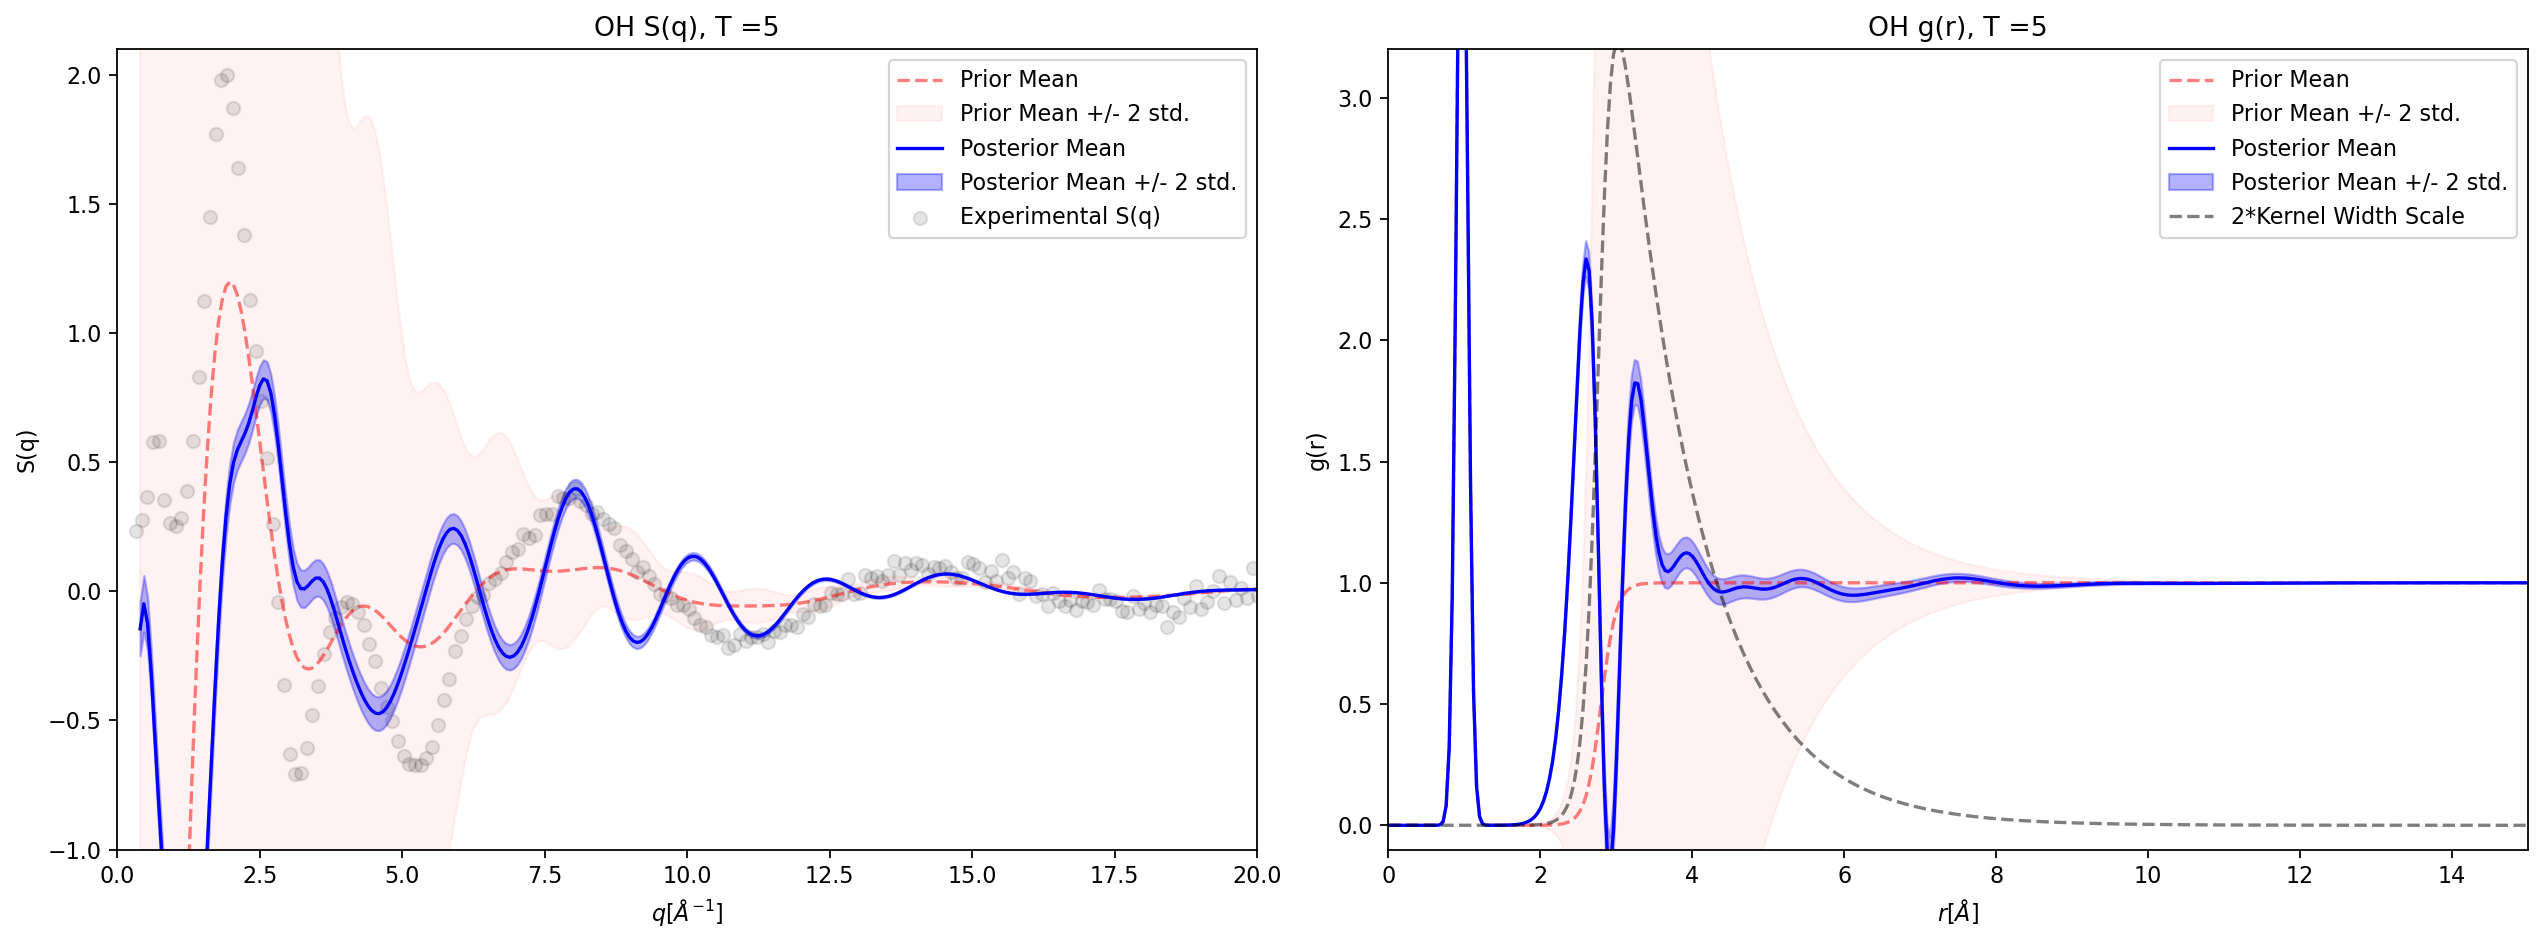

In [88]:
# # Plot Loss
# plt.figure(figsize=(10, 6))
# plt.plot(losses, linestyle='-')
# plt.xlabel('Epoch')
# plt.ylabel('-LMLH (Averaged over 10 Batches)')
# plt.title('Evolution of -LMLH During SGD')
# plt.savefig('figs/'+str(temp)+'_'+psq_name+'_LMLH.png')
# plt.show()

# Save GP
# torch.save(gp, 'models/'+str(temp)+'_'+psq_name+'_GP')


gp = gptransform.GP(init_params, init_param_bounds, bond_count[psq_name], 3*density*(1/10)**3, 69)

gp.print_params()

r_grid = torch.linspace(0.001,30,700).reshape(-1,1)
with torch.no_grad():

    q_infer = torch.linspace(0.4,20,300).reshape(-1,1)
    q_train = q_values
    sq_train = data_dict_types[temp][psq_name]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=160)

    # First Plot: S(q)
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()

    axs[0].plot(q_infer.T[0], μ_q_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    axs[0].fill_between(q_infer.T[0], μ_q_prior.T[0] + 2*torch.diag(Σ_q_prior)**0.5, μ_q_prior.T[0] - 2*torch.diag(Σ_q_prior)**0.5, alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
    axs[0].plot(q_infer.T[0], μ_q_post.T[0], label="Posterior Mean", color='b')
    axs[0].fill_between(q_infer.T[0], μ_q_post.T[0] + 2*torch.diag(Σ_q_post)**0.5, μ_q_post.T[0] - 2*torch.diag(Σ_q_post)**0.5, alpha=0.3, label="Posterior Mean +/- 2 std.", color='b')
    axs[0].scatter(q_train, sq_train, label='Experimental S(q)', alpha=0.1, color='k')
    axs[0].set_xlim(0, 20)
    axs[0].set_ylim(ylims[psq_name+'lo'],ylims[psq_name+'hi'])
    axs[0].set_title(psq_name + ' S(q), T =' + str(temp))
    axs[0].set_xlabel('$q [Å^{-1}]$')
    axs[0].set_ylabel('S(q)')
    axs[0].legend()

    # Second Plot: g(r)
    Σ_r_prior = gp.K_rr(r_infer,r_infer).detach()
    μ_r_prior = gp.mean_r(r_infer).detach()
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train, adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()

    axs[1].plot(r_infer.T[0], μ_r_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    axs[1].fill_between(r_infer.T[0], μ_r_prior.T[0] + 2*torch.diag(Σ_r_prior)**0.5, μ_r_prior.T[0] - 2*torch.diag(Σ_r_prior)**0.5, alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
    axs[1].plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
    axs[1].fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=0.3, label="Posterior Mean +/- 2 std.", color='b')
#                     axs[1].plot(r_infer.T[0],gp.length_fxn(r_infer.T[0],gp.theta[0],gp.theta[1],gp.theta[2]).detach(),label='Kernel Length Scale',linestyle='dashed',color='rebeccapurple',alpha=0.5)
    axs[1].plot(r_infer.T[0],gp.width_fxn(r_infer.T[0],gp.theta[1],gp.theta[2],gp.theta[3],gp.theta[4]).detach(),label='2*Kernel Width Scale',linestyle='dashed',color='k',alpha=0.5)
    axs[1].set_ylim(-0.1, 3.2)
    axs[1].set_xlim(0, 15)
    axs[1].set_title(psq_name + ' g(r), T =' + str(temp))
    axs[1].set_xlabel('$r [Å]$')
    axs[1].set_ylabel('g(r)')
    axs[1].legend()

    plt.tight_layout()
    plt.savefig('figs/'+str(temp)+'_'+psq_name+'_post.png')
    plt.show()


In [79]:
### Posterior Plots ### 
        
# Outer loop over temperatures

    # Inner loop over structural types
    
        # Infer S(q)
        
        # Plot GP Prior
        
        # Plot GP Posterior
        
        # Plot Exp
        
        
        
        # Infer g(r)
        
        # Plot GP Prior
        
        # Plot GP Posterior
        
        # Plot EPSR
        

### Hyper parameter plots as a function  of temperature ###

# Create array of dimension [number of temps, number of structure types, number of hps]

# Outer loop over temperatures

    # Inner loop over structural types
    
        # Add data to appropriate cell in array
        

# plot hps as a function of temperature

In [10]:
gp.print_params()

l:       0.570101 
max:     0.958906 
slope:   49.397446 
loc:     3.173300 
decay:   0.680405 
sigma_n: 0.076244 
r_0:     3.157583 
s:       49.502228 
h:   4.990875 
r:   0.984392 
s:   0.048852 


tensor([ 1.2513,  2.9979, 22.3373,  2.4926,  0.3209,  0.0921,  2.6197,  8.2786])

l:       0.760000 
max:     1.000000 
slope:   22.337301 
loc:     2.492600 
decay:   0.531289 
sigma_n: 0.094453 
r_0:     2.617873 
s:       38.986046 


l:       0.511800 
max:     0.812900 
slope:   22.337301 
loc:     2.492600 
decay:   0.531300 
sigma_n: 0.094500 
r_0:     2.617900 
s:       38.986000 
-1521.87744140625

l:       1.200000 
max:     2.300000 
slope:   22.337301 
loc:     2.492600 
decay:   0.531300 
sigma_n: 0.094500 
r_0:     2.700000 
s:       38.986000 
-1803.51220703125


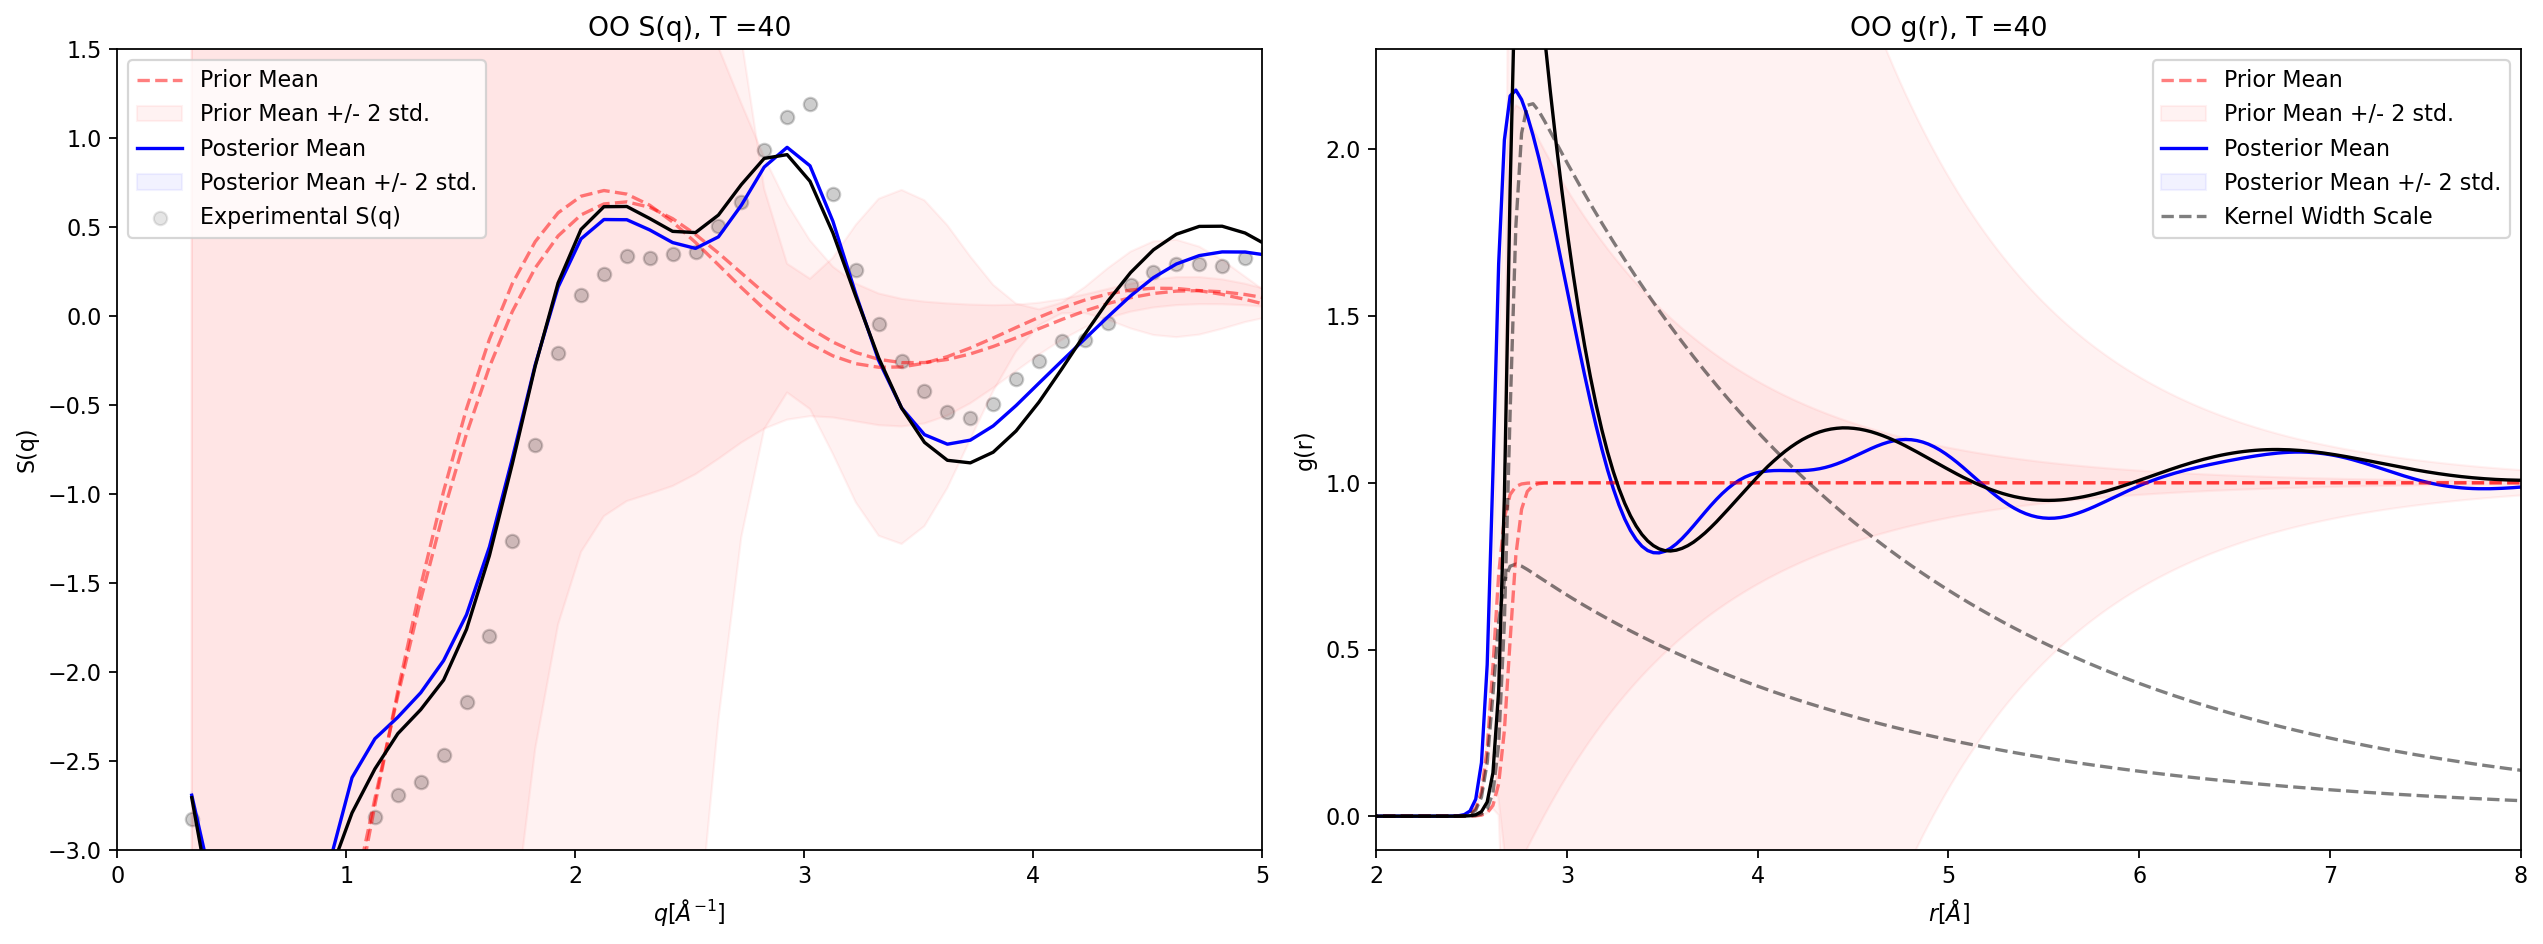

In [40]:
init_params = torch.tensor([ 0.5118,  0.8129, 22.3373,  2.4926,  0.5313,  0.0945,  2.6179, 38.9860])#gp.compute_params_from_raw().detach() 
gp = gptransform.GP(init_params, init_param_bounds, bond_count[psq_name], density*3*(1/10)**3, 69)

gp.print_params()

with torch.no_grad():
    
    for batch, (X, y) in enumerate(dataset_OO):
        # Compute prediction and loss
        loss += gp.NEG_LMLH_Trapz(r_grid, X[0], y[0])
    print(loss.item())
    
    q_train = q_values
    sq_train = data_dict_types[temp][psq_name]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=160)

    # First Plot: S(q)
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()

    axs[0].plot(q_infer.T[0], μ_q_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    axs[0].fill_between(q_infer.T[0], μ_q_prior.T[0] + 2*torch.diag(Σ_q_prior), μ_q_prior.T[0] - 2*torch.diag(Σ_q_prior), alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
    axs[0].plot(q_infer.T[0], μ_q_post.T[0], label="Posterior Mean", color='b')
    axs[0].fill_between(q_infer.T[0], μ_q_post.T[0] + 2*torch.diag(Σ_q_post), μ_q_post.T[0] - 2*torch.diag(Σ_q_post), alpha=0.05, label="Posterior Mean +/- 2 std.", color='b')
    axs[0].scatter(q_train, sq_train, label='Experimental S(q)', alpha=0.1, color='k')
    axs[0].set_xlim(0, 15)
    axs[0].set_ylim(ylims[psq_name+'lo'],ylims[psq_name+'hi'])
    axs[0].set_title(psq_name + ' S(q), T =' + str(temp))
    axs[0].set_xlabel('$q [Å^{-1}]$')
    axs[0].set_ylabel('S(q)')
    axs[0].legend()

    # Second Plot: g(r)
    Σ_r_prior = gp.K_rr(r_infer,r_infer).detach()
    μ_r_prior = gp.mean_r(r_infer).detach()
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()

    axs[1].plot(r_infer.T[0], μ_r_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    axs[1].fill_between(r_infer.T[0], μ_r_prior.T[0] + 2*torch.diag(Σ_r_prior), μ_r_prior.T[0] - 2*torch.diag(Σ_r_prior), alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
    axs[1].plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
    axs[1].fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post), μ_r_post.T[0] - 2*torch.diag(Σ_r_post), alpha=0.05, label="Posterior Mean +/- 2 std.", color='b')
#                     axs[1].plot(r_infer.T[0],gp.length_fxn(r_infer.T[0],gp.theta[0],gp.theta[1],gp.theta[2]).detach(),label='Kernel Length Scale',linestyle='dashed',color='rebeccapurple',alpha=0.5)
    axs[1].plot(r_infer.T[0],gp.width_fxn(r_infer.T[0],gp.theta[1],gp.theta[7],gp.theta[6],gp.theta[4]).detach(),label='Kernel Width Scale',linestyle='dashed',color='k',alpha=0.5)
    axs[1].set_ylim(-0.1, 3.2)
    axs[1].set_xlim(0, 15)
    axs[1].set_title(psq_name + ' g(r), T =' + str(temp))
    axs[1].set_xlabel('$r [Å]$')
    axs[1].set_ylabel('g(r)')
    axs[1].legend()
    

    plt.tight_layout()

print()
init_params = gp.compute_params_from_raw().detach() 
init_params[0] = 1.2
init_params[1] = 2.3
init_params[-2] = 2.7 
gp = gptransform.GP(init_params, init_param_bounds, bond_count[psq_name], density*3*(1/10)**3, 69)

gp.print_params()

with torch.no_grad():
    
    for batch, (X, y) in enumerate(dataset_OO):
        # Compute prediction and loss
        loss += gp.NEG_LMLH_Trapz(r_grid, X[0], y[0])
    print(loss.item())

    # First Plot: S(q)
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()

    axs[0].plot(q_infer.T[0], μ_q_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    axs[0].fill_between(q_infer.T[0], μ_q_prior.T[0] + 2*torch.diag(Σ_q_prior), μ_q_prior.T[0] - 2*torch.diag(Σ_q_prior), alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
    axs[0].plot(q_infer.T[0], μ_q_post.T[0], label="Posterior Mean", color='k')
    axs[0].fill_between(q_infer.T[0], μ_q_post.T[0] + 2*torch.diag(Σ_q_post), μ_q_post.T[0] - 2*torch.diag(Σ_q_post), alpha=0.05, label="Posterior Mean +/- 2 std.", color='b')
    axs[0].scatter(q_train, sq_train, label='Experimental S(q)', alpha=0.1, color='k')
    axs[0].set_ylim(-3, 1.5)
    axs[0].set_xlim(0, 5)
    axs[0].set_title(psq_name + ' S(q), T =' + str(temp))
    axs[0].set_xlabel('$q [Å^{-1}]$')
    axs[0].set_ylabel('S(q)')
    # axs[0].legend()

    # Second Plot: g(r)
    Σ_r_prior = gp.K_rr(r_infer,r_infer).detach()
    μ_r_prior = gp.mean_r(r_infer).detach()
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()

    axs[1].plot(r_infer.T[0], μ_r_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    axs[1].fill_between(r_infer.T[0], μ_r_prior.T[0] + 2*torch.diag(Σ_r_prior), μ_r_prior.T[0] - 2*torch.diag(Σ_r_prior), alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
    axs[1].plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='k')
    axs[1].fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post), μ_r_post.T[0] - 2*torch.diag(Σ_r_post), alpha=0.05, label="Posterior Mean +/- 2 std.", color='b')
#                     axs[1].plot(r_infer.T[0],gp.length_fxn(r_infer.T[0],gp.theta[0],gp.theta[1],gp.theta[2]).detach(),label='Kernel Length Scale',linestyle='dashed',color='rebeccapurple',alpha=0.5)
    axs[1].plot(r_infer.T[0],gp.width_fxn(r_infer.T[0],gp.theta[1],gp.theta[7],gp.theta[6],gp.theta[4]).detach(),label='Kernel Width Scale',linestyle='dashed',color='k',alpha=0.5)
    axs[1].set_ylim(-0.1, 2.3)
    axs[1].set_xlim(2, 8)
    axs[1].set_title(psq_name + ' g(r), T =' + str(temp))
    axs[1].set_xlabel('$r [Å]$')
    axs[1].set_ylabel('g(r)')
    # axs[1].legend()
    

    plt.tight_layout()
    plt.savefig('figs/'+str(temp)+'_'+psq_name+'_post.png')
    

    plt.show()

-618.9722900390625
